In [1]:
%load_ext autoreload
%autoreload 2

# https://www.ishares.com/us/products/239706/ishares-russell-1000-growth-etf
# https://aroussi.com/post/python-yahoo-finance
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import pandas as pd
import pickle

# Download Yahoo Data (5 minute interval)

In [15]:
import YahooStocks

tix = "MSFT AAPL GOOG TSLA AMZN FB KIRK V MA UNH NFLX CRM NKE HD COST KO AMT LOW UPS ZM MMM"
# Initialize
stocks = YahooStocks.Stocks(tix)
# Download Yahoo and transform
stocks.get_data(interval = '30m')
stocks.transform_data()
# Write to transformed data to SQL
stocks.insert_SQL()
# Read from SQL
stocks.read_SQL('stockprice')

[*********************100%***********************]  21 of 21 completed


In [16]:
stocks.transformed_data.to_csv('data/mydata.csv')

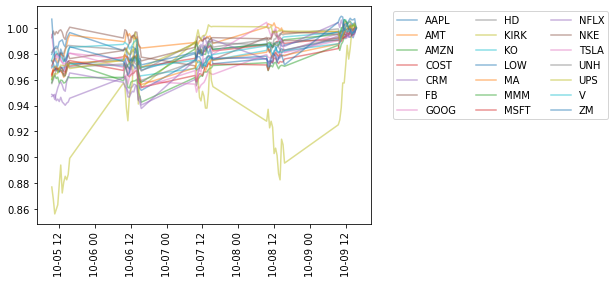

In [17]:
stocks.plot_raw(scale = -1)

# Model

In [18]:
# Prepare Data
# Pivot so each stock time series is a column
data = stocks.transformed_data.pivot_table(columns = 'symbol', index = 'DateTime')['price']
# Normalize by Last Value
data = data/data.iloc[-1]

In [19]:
M = YahooStocks.Model(data=data)

In [23]:
M.fitVAR(20)

/home/erichullander/anaconda3/envs/StockPrice/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [28]:
M.forecast(10)

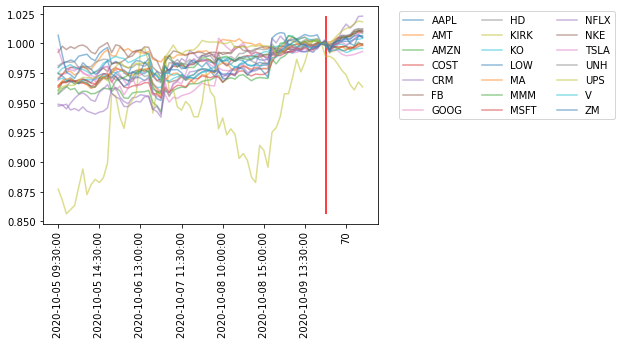

In [29]:
M.plot_fcast()

In [32]:
M.fcast.iloc[-1].sort_values(ascending = False)

symbol
NFLX    1.022971
UPS     1.018162
UNH     1.012362
NKE     1.011720
HD      1.010450
CRM     1.010322
AMT     1.009945
COST    1.009845
TSLA    1.009159
MMM     1.008549
AAPL    1.006599
ZM      1.005370
LOW     1.004992
KO      1.004280
MSFT    0.999677
AMZN    0.998663
FB      0.998496
MA      0.998185
V       0.995728
GOOG    0.993099
KIRK    0.963254
Name: 74, dtype: float64